### big thanks to : https://github.com/ultralytics/yolov5, alladin pearson (youtube), that one chinese blog with diagrams

In [44]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader

In [3]:
INPUT_DIRECTORY = os.path.join("..","input")
NFL_INPUT_DATA_DIRECTORY = os.path.join(INPUT_DIRECTORY,"nfl-health-and-safety-helmet-assignment")

In [4]:
input_image_labels_df = pd.read_csv(os.path.join(NFL_INPUT_DATA_DIRECTORY,'image_labels.csv'))
input_image_labels_df

,image,label,left,width,top,height
0,57503_000116_Endzone_frame443.jpg,Helmet,1099,16,456,15
1,57503_000116_Endzone_frame443.jpg,Helmet,1117,15,478,16
2,57503_000116_Endzone_frame443.jpg,Helmet,828,16,511,15
3,57503_000116_Endzone_frame443.jpg,Helmet,746,16,519,16
4,57503_000116_Endzone_frame443.jpg,Helmet,678,17,554,17
...,...,...,...,...,...,...
193731,58167_003154_Endzone_frame0808.jpg,Helmet,928,29,549,23
193732,58167_003154_Endzone_frame0808.jpg,Helmet,1149,25,278,23
193733,58167_003154_Endzone_frame0808.jpg,Helmet,839,31,663,29
193734,58167_003154_Endzone_frame0808.jpg,Helmet,918,29,680,25


In [102]:
list(input_image_labels_df['label'].value_counts().keys())

['Helmet',
 'Helmet-Blurred',
 'Helmet-Sideline',
 'Helmet-Partial',
 'Helmet-Difficult']

In [134]:
use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
model = None

(368, 640, 3)


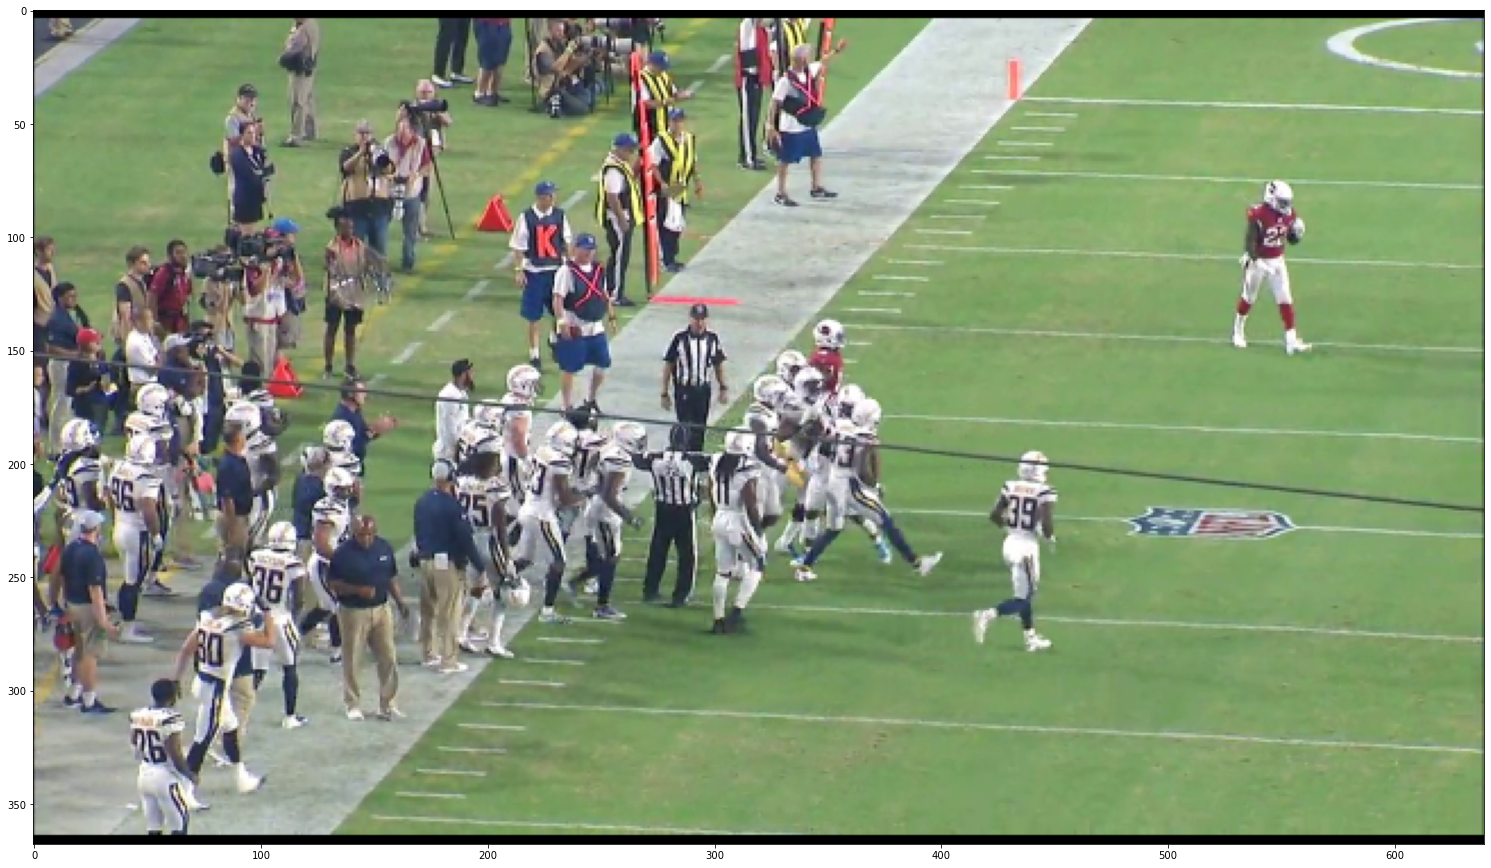

In [159]:
class NflHelmetDetectionDataset(Dataset):
    def __init__(self, input_image_labels_file=None, input_image_dir=None, transform=None, target_transform=None, stride=32, resolution=(736,1280)):
        """
        `stride`: stride is power of 2, image has to be of size such that if we divide by stride it stays uniform. 32 because we'll have downscaling happening 5 times (if its' P6 then 64)
        `resolution`: multiple of `stride` , height, width
        """
        if input_image_labels_file is None:
            input_image_labels_file = os.path.join(NFL_INPUT_DATA_DIRECTORY,'image_labels.csv')
        if input_image_dir is None:
            input_image_dir = os.path.join(NFL_INPUT_DATA_DIRECTORY,'images')
        
        
        self.labels_all = pd.read_csv(input_image_labels_file)
        self.labels = self.labels_all['image'].unique()
        self.img_dir = input_image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.stride = stride
        self.resolution = resolution
        
    #TODO: we'll ignore helmet subtypes for now, but let's revisit this later
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image_name = self.labels[idx]

        
        # rows, column which might look like it's returning height,width
        image = cv2.imread(os.path.join(self.img_dir,image_name))
        
        old_shape = image.shape[:2]
        new_shape = self.resolution
        r = min(new_shape[0] / old_shape[0], new_shape[1] / old_shape[1])
        # r = min(r, 1.0) # this will force it to only scale down and never scale up
        ratio = r, r  # width, height ratios
        new_unpad = int(round(old_shape[1] * r)), int(round(old_shape[0] * r))
        
#         print(new_shape)
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        dw /= 2  # divide padding into 2 sides
        dh /= 2
        
    
        image = cv2.resize(image, new_unpad, interpolation = cv2.INTER_LINEAR)
        
        
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))  # add border
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         print('ratio',ratio, 'dwdh',(dw,dh))
        boxes = []
        
        for idx, row in self.labels_all.query(f"image=='{image_name}'").iterrows():
            boxes.append([
                torch.tensor((row.at['left']*ratio[0])+dw),
                
                torch.tensor((row.at['top']*ratio[1])+dh),
                torch.tensor(row.at['width']*ratio[0]),
                torch.tensor(row.at['height']*ratio[1]),
            ])
        return torch.tensor(image,dtype=torch.uint8).permute(2,0,1), {'boxes':torch.tensor(boxes)}
    
    @staticmethod
    def collate_fn(batch):
        img,label = zip(*batch)  # transposed
#             for i, l in enumerate(label):
#                 l[:, 0] = i  # add target image index for build_targets()
        return torch.stack(img, 0), 4 #, torch.cat(label, 0), path, shapes

if __name__ == "__main__":
    nfl_helmet_detection_ds = NflHelmetDetectionDataset(resolution=(736//2,1280//2))
    len(nfl_helmet_detection_ds)
    idx = 2
    x = nfl_helmet_detection_ds[idx][0]
    y = nfl_helmet_detection_ds[idx][1]
#     x = x.permute(2,0,1)
   
    image = x.permute(1,2,0).detach().numpy()
    print(image.shape)
#     for label_detection in y:
# #         print(label_detection)
#         cv2.rectangle(
#                     image,
#                     (label_detection['left'], label_detection['top']),
#                     (label_detection['left'] + label_detection['width'], label_detection['top'] + label_detection['height']),
#                     (255,255,20) if label_detection['label'] == 'Helmet-Sideline' else (255,20,0),
#                     thickness=1,
#                 )
#         cv2.putText(
#                 x,
#                 label_detection['label'],
#                 (label_detection['left'], label_detection['top']),
#                 cv2.FONT_HERSHEY_SIMPLEX,
#                 0.5,
#                 (255,255,255),
#                 thickness=1,
#             )
    plt.figure(figsize=(26,18))
    plt.imshow(image)

#     print(x.size())

In [154]:
NflHelmetDetectionDataset.collate_fn

<function __main__.NflHelmetDetectionDataset.collate_fn(batch)>

In [165]:
nfl_helmet_detection_ds = NflHelmetDetectionDataset(resolution=(736//2,1280//2))
train_dataloader = DataLoader(nfl_helmet_detection_ds, batch_size=16, shuffle=False, collate_fn=NflHelmetDetectionDataset.collate_fn)
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return int(p)

class Conv2d(torch.nn.Module):
    def __init__(self, channels_in, channels_out, filter_size=1, stride=1, padding=None, groups=1, activation=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        
        self.conv = torch.nn.Conv2d(channels_in, channels_out, filter_size, stride, autopad(filter_size, padding), groups=groups, bias=False)
        print(self.conv)
        self.bn = torch.nn.BatchNorm2d(channels_out)
        self.act = torch.nn.Hardswish() if activation is True else (activation if isinstance(activation, torch.nn.Module) else torch.nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

class Conv2dObjectDetect(torch.nn.Module):
    def __init__(self, channels_in, num_classes):
        super().__init__()
        self.conv = torch.nn.Conv2d(channels_in, 1+4+)
    
    
class Yolo5Bs(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.
    
model = Conv2d(3,1, filter_size=3)
for batch_idx, (x,y) in enumerate(train_dataloader):
    x = x.float()/255.0
#     print(y.)
    print(x.size())
    model(x)

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])
torch.Size([16, 3, 368, 640])


KeyboardInterrupt: 

In [119]:
# del model
# del loss
# losses_train = []
# losses_test = []
torch.cuda.empty_cache()
import gc
gc.collect()

29469

NameError: name 'c2' is not defined